In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("models")), '..'))

In [3]:
from models import cosTube

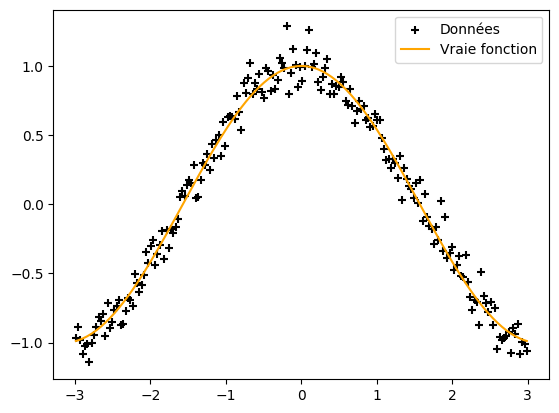

In [4]:
# Definition de la fonction de test
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return np.cos(x) + epsilon

# Paramétrage des données d'entrainements
train_size = 200
# Le bruite
noise = 0.1

# Pour cos
xmin = -3
xmax = 3

zoomfig = 2
xminBig = xmin - zoomfig * (xmax - xmin)
xmaxBig = xmax + zoomfig * (xmax - xmin)

XBig = np.linspace(xminBig, xmaxBig, train_size *
                   (2*zoomfig + 1)).reshape(-1, 1)
X = XBig[train_size * zoomfig: train_size * zoomfig + train_size]
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)


# On affiche tout ça
plt.close()
plt.scatter(X, y, marker='+', label='Données', color = 'k')
plt.plot(X, y_true, label='Vraie fonction', color = 'orange')
plt.legend()
plt.show()

In [5]:
tX = torch.Tensor(X)
tXBig = torch.Tensor(XBig)
ty = torch.Tensor(y)

print("tX.shape : ", tX.shape)
print("tXBig.shape : ", tXBig.shape)
print("ty.shape : ", ty.shape)

tX.shape :  torch.Size([200, 1])
tXBig.shape :  torch.Size([1000, 1])
ty.shape :  torch.Size([200, 1])


In [6]:
# Hypperparamètres
N = 5000
ns = [1, 2, 1]
lmax = 6

P0 = 0.1
epsilon = 1e-3
fact = 0.1
sigma_0 = (lmax + 1) * fact

# Temperature initial
Temp = 0.5

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

args = {"N" : N, "lmax" : lmax, "ns" : ns, "P0" : P0, 
        "epsilon" : epsilon, "fact" : fact, "sigma_0" : sigma_0,
        "Temp" : Temp, "pdist" : pdist}

In [7]:
myModel = cosTube.resNet(1, 1)

In [8]:
thetas, rhoMin, epsJ, rhoMax = cosTube.trainBNN(args, tX, ty, myModel)

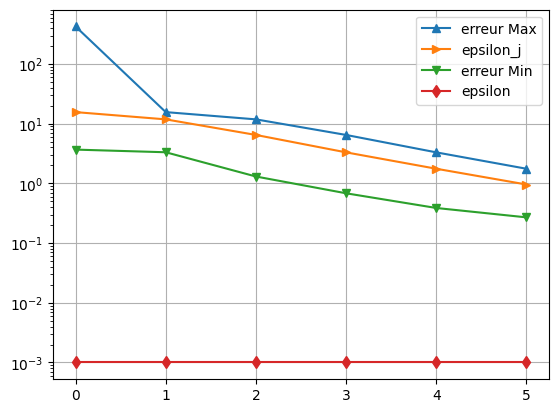

In [9]:
plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(np.ones(len(rhoMin)) * epsilon, label = 'epsilon', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

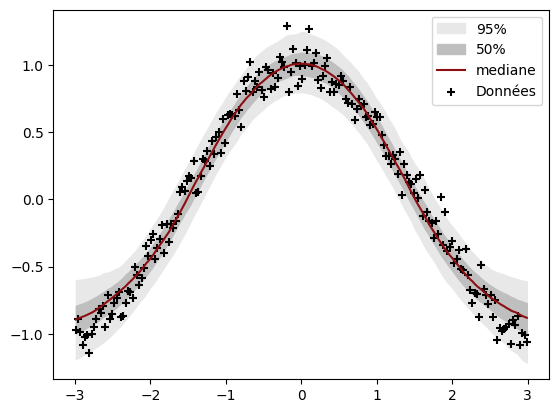

In [10]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)


q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

plt.clf()


plt.fill_between(tX.ravel().numpy(), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(tX.ravel().numpy(), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(tX, med, label="mediane", color="#8c0e11")

plt.scatter(tX,ty, marker='+', color='k', label='Données')

plt.legend()
plt.show()


In [11]:
thetaRavel = torch.concatenate(tuple([torch.concatenate(tuple([p.ravel() for p in theta])).reshape(-1,1) for theta in thetas]), 1)

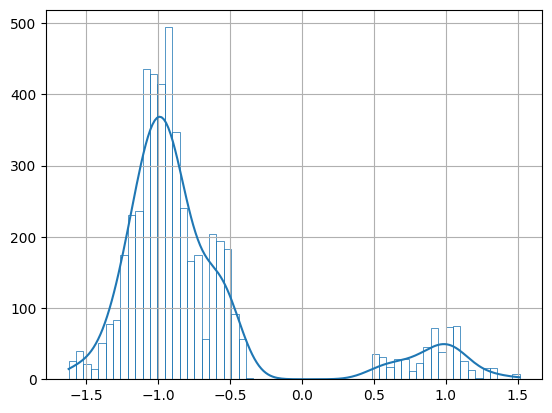

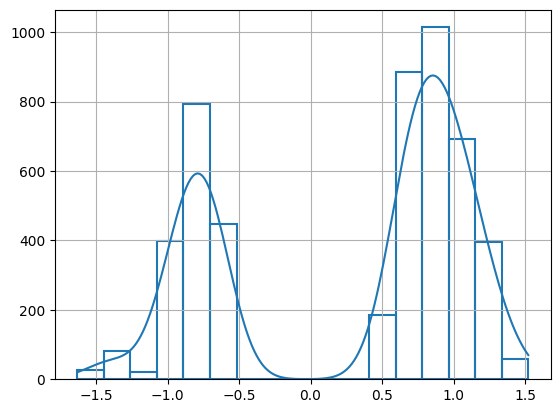

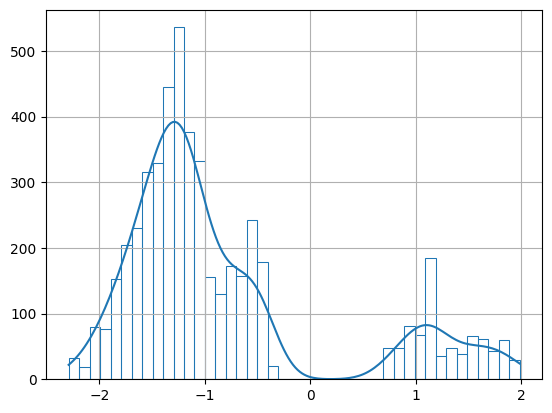

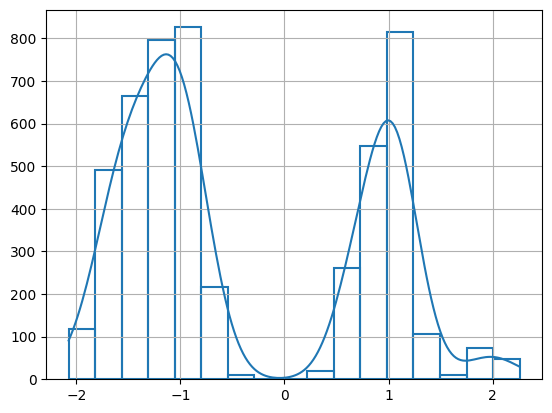

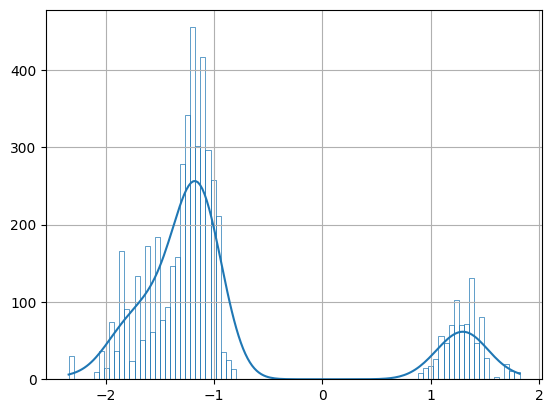

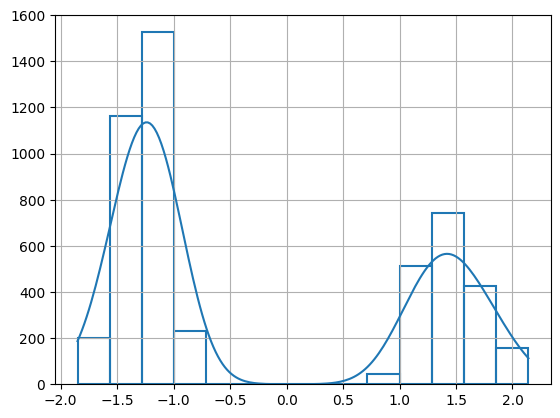

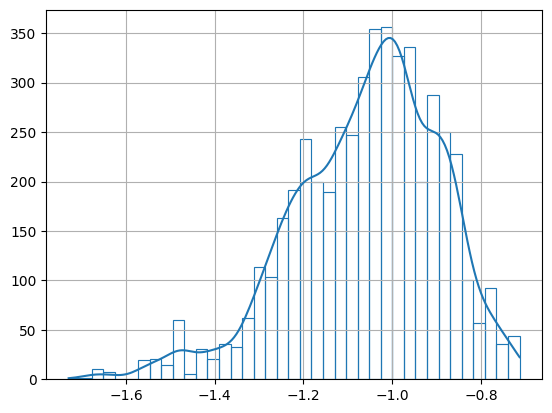

In [12]:
for k in range(thetaRavel.shape[0]) :
    plt.figure()
    sns.histplot(thetaRavel[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

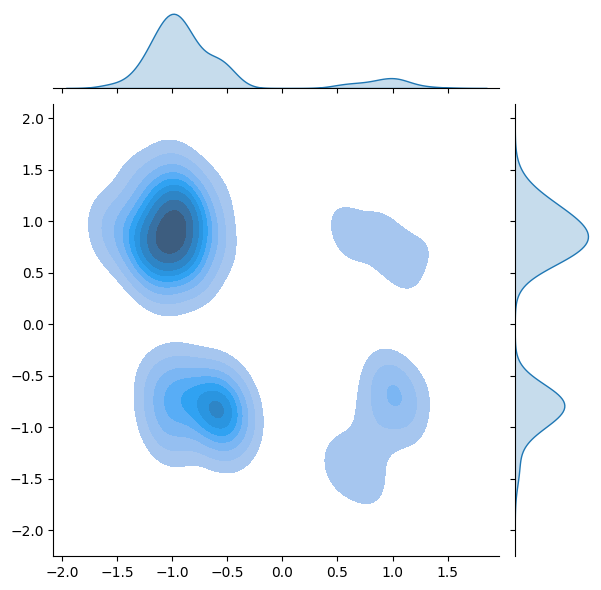

In [13]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetaRavel[s,:].detach().numpy(), y = thetaRavel[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()

In [14]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tXBig) for theta in thetas]), 1)


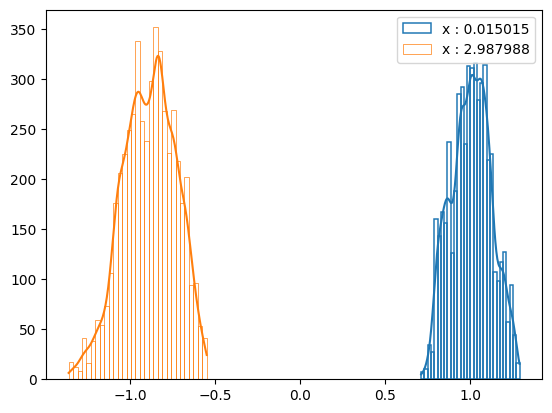

In [15]:
middle = torch.argmin(torch.abs(tXBig))
left = middle + 100
sns.histplot(y_hats[middle + 1,:].detach().numpy(), kde = True, label = 'x : {:2f}'.format(tXBig[middle+1][0]), fill = None)
sns.histplot(y_hats[left,:].detach().numpy(), kde = True, label = 'x : {:2f}'.format(tXBig[left][0]), fill = None)
plt.ylabel(None)
plt.legend()